In [14]:
# import packages

import torch
import math as m
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams.update({'font.family': 'serif', 'font.size': 10})
matplotlib.rcParams['text.usetex'] = True
from matplotlib.lines import Line2D

from scipy.interpolate import griddata
from scipy import integrate
import time

np.random.seed(1234)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e+00 ...  4.990e+02  5.000e+02]
        y: [[ 1.000e+00  9.665e-01 ...  4.230e-01  4.227e-01]
            [ 3.651e-05  3.074e-05 ...  2.888e-06  2.885e-06]
            [ 0.000e+00  3.354e-02 ...  5.771e-01  5.773e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 164
     njev: 11
      nlu: 40


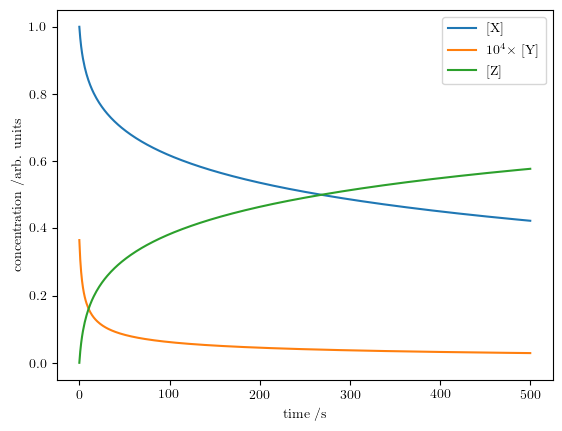

array([[1.00000000e+00, 3.65148372e-05, 0.00000000e+00],
       [9.66469051e-01, 3.07424404e-05, 3.35367215e-02],
       [9.41624593e-01, 2.70150602e-05, 5.83849071e-02],
       ...,
       [4.23201245e-01, 2.89092757e-06, 5.76832379e-01],
       [4.22950976e-01, 2.88801303e-06, 5.77082651e-01],
       [4.22701198e-01, 2.88510594e-06, 5.77332432e-01]])

In [15]:
# Solve Robertson equation under the QSSA assumption with an explicit
# Runge-Kutta method.

y_qssa = lambda x, z : (-10**4 * z + (10**8 * z**2 + 4 * 0.04 * 3 * 10**7 * x)**(0.5)) / (2 * 3 * 10**7)

# chemical reaction of Robertson:
# dx/dt = -0.04 * x + 10**4 * y * z
# dy/dt = 0.04 * x - 10**4 * y * z - 3 * 10**7 * y**2
# dz/dt = 3 * 10**7 * y**2
def rhs_robertson (t, v):
    x, y, z = v
    dx_dt = -0.04 * x + 10**4 * y * z
    dy_dt = 0.04 * x - 10**4 * y * z - 3 * 10**7 * y**2
    dz_dt = 3 * 10**7 * y**2
    return dx_dt, dy_dt, dz_dt

def gen_numerical_reference_robertson (max_t_pred, delta_t, y0):
    t = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)

    sol = integrate.solve_ivp(rhs_robertson, (0, max_t_pred), (y0[0], y0[1], y0[2]), t_eval=t, method = 'Radau')
    
    # Output solution
    print (sol)
    YFAC = 4
    plt.plot(sol.t, sol.y[0], label='[X]')
    plt.plot(sol.t, 10**YFAC*sol.y[1], label=r'$10^4 \times$ [Y]'.format(YFAC))
    plt.plot(sol.t, sol.y[2], label='[Z]')
    plt.xlabel('time /s')
    plt.ylabel('concentration /arb. units')
    plt.legend()
    plt.show()
    
    x_true, y_true, z_true = sol.y

    return np.stack((x_true, y_true, z_true), axis = 1)


x_0 = 1.0
z_0 = 0.0
gen_numerical_reference_robertson (500, 1, [x_0,y_qssa (x_0,z_0),z_0])

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e+00 ...  4.990e+02  5.000e+02]
        y: [[ 1.000e+00  9.665e-01 ...  4.232e-01  4.230e-01]
            [ 0.000e+00  3.355e-02 ...  5.768e-01  5.770e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 68
     njev: 0
      nlu: 0


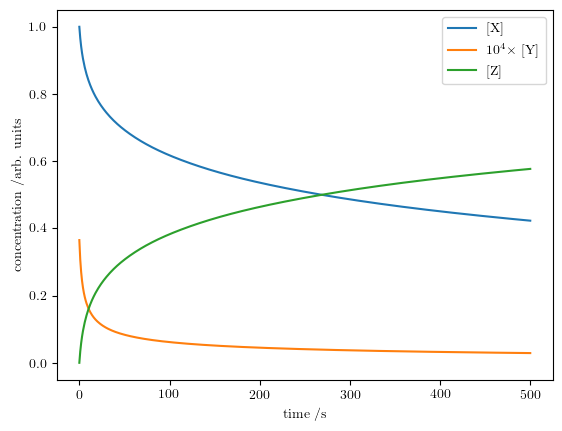

In [16]:
def rhs_robertson_qssa (t, v):
    x, z = v
    
    y = y_qssa (x, z)
    
    dx_dt = -0.04 * x + 10**4 * y * z
    dz_dt = 3 * 10**7 * y**2
    
    return dx_dt, dz_dt

def gen_numerical_reference_robertson_qssa (max_t_pred, delta_t, y0):
    t = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)

    sol = integrate.solve_ivp(rhs_robertson_qssa, (0, max_t_pred), (y0[0], y0[1]), t_eval = t)
    
    # Output solution
    print (sol)
    plt.plot(sol.t, sol.y[0], label='[X]')
    plt.plot(sol.t, 10**4*y_qssa(sol.y[0], sol.y[1]), label=r'$10^4 \times$ [Y]'.format(4))
    plt.plot(sol.t, sol.y[1], label='[Z]')
    plt.xlabel('time /s')
    plt.ylabel('concentration /arb. units')
    plt.legend()
    plt.show()
    
    x_true, z_true = sol.y

    return np.stack((x_true, y_qssa(sol.y[0], sol.y[1]), z_true), axis = 1)

# numerical reference solution
true_sol = gen_numerical_reference_robertson_qssa (500, 1, [x_0,z_0])

In [17]:
# CUDA support 

if 0:#torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [18]:
# define the deep neural network

class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        
        super().__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        
        for i in range(self.depth - 1):
            
            linear_layer = torch.nn.Linear(layers[i], layers[i+1])
            torch.nn.init.xavier_normal_(linear_layer.weight, gain=5/3)
            torch.nn.init.zeros_(linear_layer.bias.data)
            
            layer_list.append(
                (f"layer_{i}", linear_layer)
            )
            layer_list.append((f"activation_{i}", self.activation()))
        
        last_layer = torch.nn.Linear(layers[-2], layers[-1])
        torch.nn.init.xavier_normal_(last_layer.weight)
        torch.nn.init.zeros_(last_layer.bias.data)
        
        layer_list.append(
            (f"layer_{self.depth - 1}", last_layer)
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    

    def forward(self, x):
        
        # x = (t, y0)
        return self.layers(x)

In [19]:
# define the PINN: physics-informed neural network

class PINN():

    def __init__(self, X_pinn, X_semigroup, X_smooth, layers, T):

        # neural network architecture
        self.layers = layers
        self.dnn = DNN(layers).to(device)
        
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)

        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        # optimization
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), lr=1.0, max_iter=50000, max_eval=50000, 
            history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # The M(t, y0) = y0 + t N(t, y0) scheme seems to drastically increase the accuracy
        # This works perfectly fine with automatic differentiation
        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivative of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for i in range(2)]
        
        for i, vec in enumerate(vectors):
            
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        """ This is specific to the Robertson system """

        y = y_qssa (y_pred[:,0:1], y_pred[:,1:2])
        
        # reduced chemical reaction of Robertson:
        # dx/dt = -0.04x + 10**4 * y * z
        # dz/dt = 3 * 10**7 * y**2
        loss_pinn1 = torch.mean((deriv_pred[0] + 0.04 * y_pred[:,0:1] - 10**4 * y * y_pred[:,1:2]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - 3 * 10**7 * y**2) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2
        """
        print ("x")
        print (torch.mean (y_pred[:,0:1]))
        print ("y")
        print (torch.mean (y))
        print ("z")
        print (torch.mean (y_pred[:,1:2]))
        print ("loss_pinn")
        print (loss_pinn)
        """
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        # Scale by ODE dimension due to torch.mean
        loss = 2 * (loss_pinn + loss_smooth + loss_semigroup)
        """
        print ("smooth")
        print (loss_smooth)
        print ("semigroup")
        print (loss_semigroup)
        """
        
        loss.backward()
        self.iter += 1
        
        if self.iter % 100 == 0:
            print(
                f"Iter {self.iter}, Loss: {loss.item():.5f}, Loss_pinn: {loss_pinn.item():.5f} " \
                f"Loss_smooth: {loss_smooth.item():.5f}, Loss_semigroup: {loss_semigroup.item():.5f}"
            )
        
        return loss
    
    
    def train(self):
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

### Setup data example

In [20]:
layers = [3] + 6 * [128] + [2]

# TODO: Find a suitable T
T = 8 # up to now the best setup was T = 5 with 50,000 samples
# We consider concentrations that should be in [0,1]
max_y0 = 1
min_y0 = 0.1

# standard PINN loss function training samples
N_pinn = 10000
N_semigroup = 10000
N_smooth = 10000


t_pinn = np.random.uniform(0, T, (N_pinn, 1))
y_pinn = np.random.uniform(min_y0, max_y0, (N_pinn, 2))
print (y_pinn)

X_pinn = np.hstack([t_pinn, y_pinn])


r1 = np.random.uniform(0, 1, N_semigroup)
r2 = np.random.uniform(0, 1, N_semigroup)
s_semigroup, t_semigroup = np.sqrt(r1) * (1 - r2), r2 * np.sqrt(r1)
s_semigroup, t_semigroup = T * s_semigroup[:, np.newaxis], T * t_semigroup[:, np.newaxis]
y_semigroup = np.random.uniform(min_y0, max_y0, (N_semigroup, 2))
X_semigroup = np.hstack([s_semigroup, t_semigroup, y_semigroup])


t_smooth = np.random.uniform(0, T, (N_smooth, 1))
y_smooth = np.random.uniform(min_y0, max_y0, (N_smooth, 2))
X_smooth = np.hstack([t_smooth, y_smooth])

[[0.74501935 0.61673234]
 [0.70337183 0.77933188]
 [0.35490874 0.57863347]
 ...
 [0.63467044 0.57555964]
 [0.75169691 0.2084998 ]
 [0.3995703  0.65851729]]


In [21]:
# initialize the PINN

model = PINN(X_pinn, X_semigroup, X_smooth, layers, T)

In [22]:
%%time

# train the model from scratch or load an already trained model (next cell)

model.train()

Iter 100, Loss: 0.00028, Loss_pinn: 0.00010 Loss_smooth: 0.00013, Loss_semigroup: 0.00006
Iter 200, Loss: 0.00004, Loss_pinn: 0.00002 Loss_smooth: 0.00002, Loss_semigroup: 0.00001
Iter 300, Loss: 0.00001, Loss_pinn: 0.00001 Loss_smooth: 0.00001, Loss_semigroup: 0.00000
Iter 400, Loss: 0.00001, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 500, Loss: 0.00000, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 600, Loss: 0.00000, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 700, Loss: 0.00000, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 800, Loss: 0.00000, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 900, Loss: 0.00000, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 1000, Loss: 0.00000, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 1100, Loss: 0.00000, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 120

In [23]:
# save the model

import os

path = os.getcwd()

torch.save(model.dnn.state_dict(), path + '/model_new.pt')

In [ ]:
# load an already existing model, in this case in the same folder on GitHub

import os

path = os.getcwd()

model.dnn.load_state_dict(torch.load(path + '/model_new.pt'))

#print(model.dnn.state_dict())

## Predict and Plot the Solution

In [24]:
# predict the solution of the Robertson ODE

def predict_standard(model, y0, max_t_pred, delta_t):
    
    times = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
    times = times[:,np.newaxis]
    
    y0 = np.array([y0 for _ in range(len(times))])
    trajectory =  model.predict(times, y0)
    
    return trajectory


def predict_dac(model, y0, max_t_pred, delta_t):
    """
    detla_t should divide model.max_t to guarantee equidistant steps
    """
    times = np.arange(0, model.T + delta_t, delta_t)[1:]
    times = times[:,np.newaxis]
    n_resets = int(np.ceil(max_t_pred / model.T))
    
    trajectory = np.array([y0])
    
    for _ in range(n_resets):
        
        y0 = trajectory[-1]
        y0 = np.array([y0 for _ in range(len(times))])
        segment =  model.predict(times, y0)
        trajectory = np.vstack([trajectory, segment])
    
    return trajectory

In [25]:
# Compute the solution for a given initial condition
# Note that max_t in training is 10

y0 = [x_0, z_0]
max_t_pred = 500
delta_t = 0.05

validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_standard = predict_standard(model, y0, max_t_pred, delta_t)

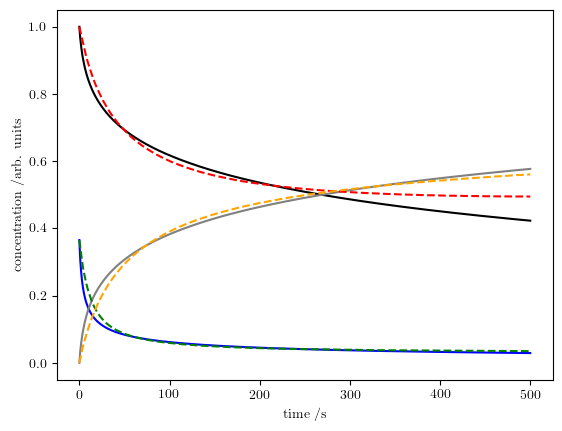

In [26]:
# plot the results and compare with the true solution

plt.xlabel('time /s')
plt.ylabel('concentration /arb. units')

t = np.linspace(0, max_t_pred, 501)
x_true = true_sol[:, 0]
y_true = true_sol[:, 1]
z_true = true_sol[:, 2]
plt.plot(t, x_true, color="black")
plt.plot(t, 10**4*
         y_true, color="blue")
plt.plot(t, z_true, color="gray")


x_pred = validation_dac[:, 0]
y_pred = validation_dac[:, 1]

t = np.linspace(0, max_t_pred, 10081)
plt.plot(t, x_pred, color="red", linestyle="dashed")
plt.plot(t, 10**4*y_qssa (x_pred, y_pred), color="green", linestyle="dashed")
plt.plot(t, y_pred, color="orange", linestyle="dashed")
# plt.legend()
plt.show()

In [ ]:
# might have to install these packages for visualization purposes before running the previous cell

! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

In [ ]:
!apt install cm-super